# Try asymmetry tests again

We wanted to test that the asymmetry measurement is robust to 
* Changing SNR
* Changing PSF
* Changing pixel scale (in terms of the PSF)
* Changing aperture size

We test different asymmetry measurements:
* CAS asymmetry |A|
* CAS asymmetry with background correction (normalization is by F, not |F|)
* Squared asymmetry A$^2$
* Squared asymmetry on a deconvolved image

First, we generate a perfect galaxy. Then for each test, we vary PSF, SNR, and pixel scale, and calculate asymmetry for each variation.

#### Imports

In [1]:
%reload_ext autoreload
%autoreload 2
import numpy as np
import matplotlib.pyplot as plt
from galaxy_generator import simulate_perfect_galaxy, add_source_to_image, sky_noise
from asymmetry import _asymmetry_center, _sky_properties, _asymmetry_func, fourier_deconvolve
from astropy.convolution import Gaussian2DKernel
from astropy.stats import gaussian_fwhm_to_sigma
from tqdm.notebook import tqdm
from photutils.aperture import CircularAperture, CircularAnnulus, ApertureStats
from skimage.transform import rescale

## Generating a galaxy
Set up all of the galaxy physical properties **and the pixel scale**

In [2]:
# Physical properties
mag = 15.5
r = 5
q = 0.5
n = 4
n_clumps = 50

# Image properties
fov = 21 # In terms of reff

# Detector properties
pxscale = 0.1#0.396

Pristine image:

In [3]:
perfect_img, params, rpet = simulate_perfect_galaxy(mag, r, pxscale, fov, n, q, 0, n_clumps)

Code to apply PSF and noise:

In [4]:
def augment(params, pxscale, psf_fwhm, sky_mag):
    
    image_psf = add_source_to_image(**params, psf_fwhm=psf_fwhm, pxscale=pxscale, psf_method="astropy")
    image_noise, noise = sky_noise(image_psf, sky_mag=sky_mag, pixel_scale=pxscale, rms_noise=True)
    
    return image_noise, noise

## Calculate A

Use the various functions to get different A estimates to compare

In [5]:
def get_a_values(img, ap_size, pxscale, psf_fwhm):
    
    # Calculate background asymmetry
    bgsize = int(0.1*img.shape[0]) # 10% of the image
    sky_a, sky_norm, sky_std = _sky_properties(img, bgsize, a_type='squared')
    
    # Calculate the centre of the squared asymmetry
    x0 = _asymmetry_center(img, ap_size, sky_a, a_type='squared')
    
    # Get snr
    ap_source = CircularAperture(x0, ap_size)
    ap_bg = CircularAnnulus(x0, r_in=1.5*ap_size, r_out=2*ap_size)
    bg_std = ApertureStats(img, ap_bg).std
    snr = ap_source.do_photometry(img)[0][0] / bg_std / ap_source.area
    
    # Deconvolve the image
    psf_sigma = psf_fwhm  * gaussian_fwhm_to_sigma / pxscale
    psf = Gaussian2DKernel(psf_sigma, x_size=img.shape[1], y_size=img.shape[0])
    img_deconv = fourier_deconvolve(img, psf, sky_std)
    
    # Calculate the different asymmetry values, with proper bg subtraction
    cas_a = _asymmetry_func(x0, img, ap_size, 'cas', 'annulus', bg_corr='residual')
    cas_a_corr = _asymmetry_func(x0, img, ap_size, 'cas_corr', 'annulus', bg_corr='residual')
    cas_sq_corr = _asymmetry_func(x0, img, ap_size, 'squared', 'annulus', bg_corr='full')
    cas_fourier = _asymmetry_func(x0, img_deconv, ap_size, 'squared', 'annulus', bg_corr='full')
    
    res = [cas_a, cas_a_corr, cas_sq_corr, cas_fourier]
    return res, snr

Calculate asymmetry for the perfect case

In [6]:
ap_size = 1.5*rpet
x0_real = _asymmetry_center(perfect_img, ap_size, 0, a_type='squared')

# Calculate |A| and A^2
a_real_cas = _asymmetry_func(x0_real, perfect_img, ap_size, 'cas_corr', 'annulus', bg_corr='residual')
a_real_sq = _asymmetry_func(x0_real, perfect_img, ap_size, 'squared', 'annulus', bg_corr='full')


AssertionError: a_type should be "cas" or "squared"

In [ ]:
ap = CircularAperture(x0_real, ap_size)
plt.imshow(np.log10(perfect_img))
ap.plot(color='k', lw=1)

## Unresolved PSF case

Here we make the pixel scale at least half the PSF FWHM so that the PSF is well-resolved (but also, the PSF will affect the measurement of $A^2$.

### Changing SNR

Get N random sky brightness values, fix the PSF

In [18]:
psf_fwhm = 1.5 #1.3 # SDSS-like

mag_min = 21
mag_max = 30
n_iterations = 50
mags = np.random.random(n_iterations)*(mag_max - mag_min) + mag_min

Run the asymmetry calculations:

In [19]:
rs = np.linspace(0.8, 3, 15)
a_arr = []
snr_arr = []

for mag in tqdm(mags):
    
    img, noise = augment(params, pxscale, psf_fwhm, mag)
    scale = pxscale/psf_fwhm
    img = rescale(img, scale) / scale**2
    
    a, snr = get_a_values(img, ap_size*scale, pxscale/scale, psf_fwhm)
    a_arr.append(a)
    snr_arr.append(snr)
    
a_arr = np.array(a_arr).T
snr_arr = np.array(snr_arr)

  0%|          | 0/50 [00:00<?, ?it/s]

In [20]:
_sky_properties(img, 10, a_type='squared')

(180.29505469230492, 13.311925204461124, 2.51763797059653)

Make a plot

Text(0.5, 1.0, 'Squared')

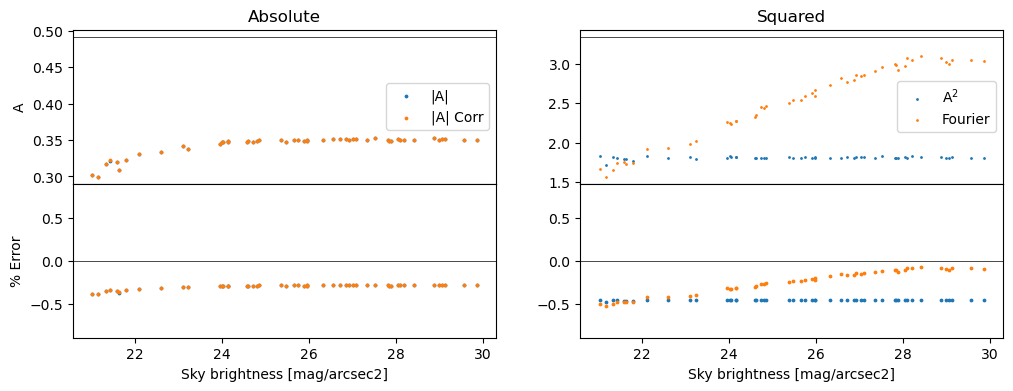

In [21]:
# Set up the figure
fig = plt.figure(figsize=(12, 4))
axs = np.zeros((2,2), dtype=object)
gs_main = fig.add_gridspec(1, 2, hspace=0.2)


##### CAS asymmetry plot
# Set axis
gs_sub = gs_main[0,0].subgridspec(2, 1, hspace=0, height_ratios=(1,1))
ax0 = fig.add_subplot(gs_sub[0])
ax1 = fig.add_subplot(gs_sub[1], sharex=ax0)
ax1.set_xlabel('Sky brightness [mag/arcsec2]')

# Plot true values
ax0.axhline(a_real_cas, color='k', lw=0.5)
ax1.axhline(0, color='k', lw=0.5)

# Scatter plot measured values
labels = ['|A|', '|A| Corr']
for i in [0, 1]:
    ax0.scatter(mags, a_arr[i], s=3, label=labels[i])
    ax1.scatter(mags, (a_arr[i]-a_real_cas)/a_real_cas, s=3)
ax0.legend()
ax1.set_ylim(-0.9, 0.9)
ax1.set_ylabel('% Error')
ax0.set_ylabel('A')
ax0.set_title('Absolute')

##### Sq asymmetry plot
# Set axis
gs_sub = gs_main[1].subgridspec(2, 1, hspace=0, height_ratios=(1,1))
ax0 = fig.add_subplot(gs_sub[0])
ax1 = fig.add_subplot(gs_sub[1], sharex=ax0)
ax1.set_xlabel('Sky brightness [mag/arcsec2]')

# Plot true values
ax0.axhline(a_real_sq, color='k', lw=0.5)
ax1.axhline(0, color='k', lw=0.5)

# Scatter plot measured values
labels = [r'A$^2$', r'Fourier']
for i in [0,1]:
    ax0.scatter(mags, a_arr[2+i], s=1, label=labels[i])
    ax1.scatter(mags, (a_arr[2+i]-a_real_sq)/a_real_sq, s=3)
ax0.legend()
ax1.set_ylim(-0.9, 0.9)
ax0.set_title('Squared')


## Resolved PSF case

### Changing SNR

In [11]:
psf_fwhm = 1.5 # SDSS-like

mag_min = 21
mag_max = 30
n_iterations = 50
mags = np.random.random(n_iterations)*(mag_max - mag_min) + mag_min


a_arr = []
snr_arr = []
for mag in tqdm(mags):
    
    img, noise = augment(params, pxscale, psf_fwhm, mag)
    a, snr = get_a_values(img, ap_size, pxscale, psf_fwhm)
    a_arr.append(a)
    snr_arr.append(snr)
    
a_arr = np.array(a_arr).T
snr_arr = np.array(snr_arr)

  0%|          | 0/50 [00:00<?, ?it/s]

Text(0.5, 1.0, 'Squared')

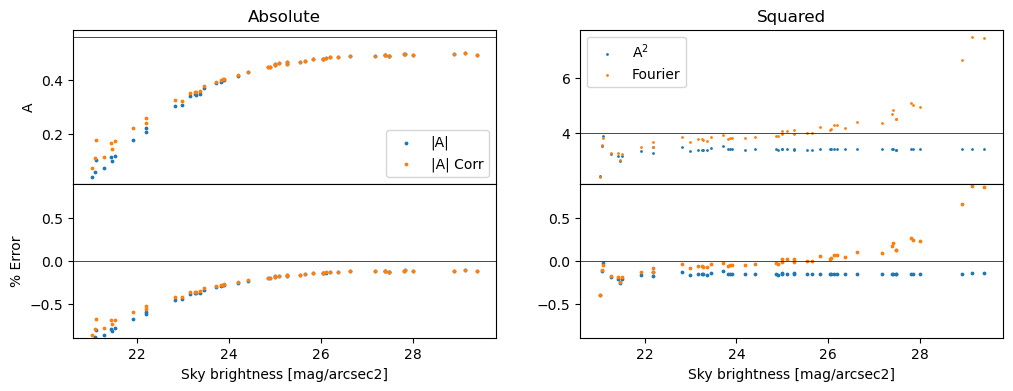

In [12]:
# Set up the figure
fig = plt.figure(figsize=(12, 4))
axs = np.zeros((2,2), dtype=object)
gs_main = fig.add_gridspec(1, 2, hspace=0.2)


##### CAS asymmetry plot
# Set axis
gs_sub = gs_main[0,0].subgridspec(2, 1, hspace=0, height_ratios=(1,1))
ax0 = fig.add_subplot(gs_sub[0])
ax1 = fig.add_subplot(gs_sub[1], sharex=ax0)
ax1.set_xlabel('Sky brightness [mag/arcsec2]')

# Plot true values
ax0.axhline(a_real_cas, color='k', lw=0.5)
ax1.axhline(0, color='k', lw=0.5)

# Scatter plot measured values
labels = ['|A|', '|A| Corr']
for i in [0, 1]:
    ax0.scatter(mags, a_arr[i], s=3, label=labels[i])
    ax1.scatter(mags, (a_arr[i]-a_real_cas)/a_real_cas, s=3)
ax0.legend()
ax1.set_ylim(-0.9, 0.9)
ax1.set_ylabel('% Error')
ax0.set_ylabel('A')
ax0.set_title('Absolute')

##### Sq asymmetry plot
# Set axis
gs_sub = gs_main[1].subgridspec(2, 1, hspace=0, height_ratios=(1,1))
ax0 = fig.add_subplot(gs_sub[0])
ax1 = fig.add_subplot(gs_sub[1], sharex=ax0)
ax1.set_xlabel('Sky brightness [mag/arcsec2]')

# Plot true values
ax0.axhline(a_real_sq, color='k', lw=0.5)
ax1.axhline(0, color='k', lw=0.5)

# Scatter plot measured values
labels = [r'A$^2$', r'Fourier']
for i in [0,1]:
    ax0.scatter(mags, a_arr[2+i], s=1, label=labels[i])
    ax1.scatter(mags, (a_arr[2+i]-a_real_sq)/a_real_sq, s=3)
ax0.legend()
ax1.set_ylim(-0.9, 0.9)
ax0.set_title('Squared')


### Changing PSF

In [13]:
mag = 23.5 # SDSS-like

psf_min = 0.6
psf_max = 2.5
n_iterations = 50
psfs = np.random.random(n_iterations)*(psf_max - psf_min) + psf_min


a_arr = []
psf_arr = []
for psf in tqdm(psfs):
    
    img, noise = augment(params, pxscale, psf, mag)
    a, snr = get_a_values(img, ap_size, pxscale, psf)
    a_arr.append(a)

    
a_arr = np.array(a_arr).T

  0%|          | 0/50 [00:00<?, ?it/s]

Text(0.5, 1.0, 'Squared')

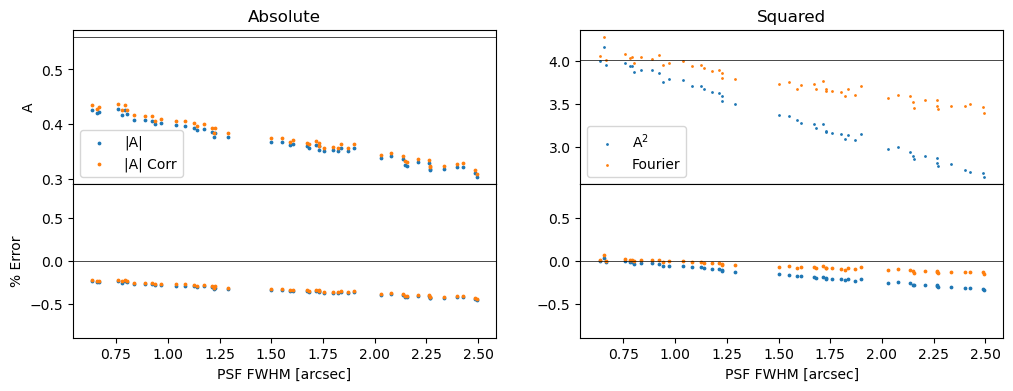

In [14]:
# Set up the figure
fig = plt.figure(figsize=(12, 4))
axs = np.zeros((2,2), dtype=object)
gs_main = fig.add_gridspec(1, 2, hspace=0.2)


##### CAS asymmetry plot
# Set axis
gs_sub = gs_main[0,0].subgridspec(2, 1, hspace=0, height_ratios=(1,1))
ax0 = fig.add_subplot(gs_sub[0])
ax1 = fig.add_subplot(gs_sub[1], sharex=ax0)
ax1.set_xlabel('PSF FWHM [arcsec]')

# Plot true values
ax0.axhline(a_real_cas, color='k', lw=0.5)
ax1.axhline(0, color='k', lw=0.5)

# Scatter plot measured values
labels = ['|A|', '|A| Corr']
for i in [0, 1]:
    ax0.scatter(psfs, a_arr[i], s=3, label=labels[i])
    ax1.scatter(psfs, (a_arr[i]-a_real_cas)/a_real_cas, s=3)
ax0.legend()
ax1.set_ylim(-0.9, 0.9)
ax1.set_ylabel('% Error')
ax0.set_ylabel('A')
ax0.set_title('Absolute')

##### Sq asymmetry plot
# Set axis
gs_sub = gs_main[1].subgridspec(2, 1, hspace=0, height_ratios=(1,1))
ax0 = fig.add_subplot(gs_sub[0])
ax1 = fig.add_subplot(gs_sub[1], sharex=ax0)
ax1.set_xlabel('PSF FWHM [arcsec]')

# Plot true values
ax0.axhline(a_real_sq, color='k', lw=0.5)
ax1.axhline(0, color='k', lw=0.5)

# Scatter plot measured values
labels = [r'A$^2$', r'Fourier']
for i in [0,1]:
    ax0.scatter(psfs, a_arr[2+i], s=1, label=labels[i])
    ax1.scatter(psfs, (a_arr[2+i]-a_real_sq)/a_real_sq, s=3)
ax0.legend()
ax1.set_ylim(-0.9, 0.9)
ax0.set_title('Squared')
